# Learning curves

MIT Open Source License: 
Copyright (c) 2018 Daniel C. Elton 

<sub>Permission is hereby granted, free of charge, to any person obtaining a copy</sub>
<sub>of this software and associated documentation files (the "Software"), to deal</sub>
<sub>in the Software without restriction, including without limitation the rights</sub>
<sub>to use, copy, modify, merge, publish, distribute, sublicense, and/or sell</sub>
<sub>copies of the Software, and to permit persons to whom the Software is</sub>
<sub>furnished to do so, subject to the following conditions:</sub>

<sub>The above copyright notice and this permission notice shall be included in all</sub>
<sub>copies or substantial portions of the Software.</sub>

<sub>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR</sub>
<sub>IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,</sub>
<sub>FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE</sub>
<sub>AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER</sub>
<sub>LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,</sub>
<sub>OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE</sub>
<sub>SOFTWARE.</sub>

In [1]:
%load_ext autoreload
%autoreload 2
from rdkit import Chem
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import  BayesianRidge, Ridge
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.utils import check_array
from sklearn.model_selection import KFold, ShuffleSplit

def fp_fun(mol):
    return FingerprintMol(mol)[0][6:37]

#Read the data
data = pd.read_excel('../datasets/combined_data.xlsx', skipfooter=83) #37

data = data.sample(frac=1).reset_index(drop=True)

#Add create Mol objects for use with RDkit
data['Mols'] = data['SMILES'].apply(Chem.MolFromSmiles)

data['Fingerprint'] = data['Mols'].apply(fp_fun)

XEstate = np.array(list(data['Fingerprint']))

num_mols = len(data)

#X = np.array(list(data['Mols'].apply(fp_fun)))
#Scale X to unit variance and zero mean
#st = StandardScaler()
#X = st.fit_transform(X)



/home/delton/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
for col in data.columns:
    print(col)

Name
short name
note
group
density g/cm3
gas-phase formation enthalpy
sublimation enthalpy
heat of explosion (kJ/g , but note sensitivity data did not report units, and values are different?) 
detonation velocity (km/s)
detonation pressure (GPa)
Gurney energy
h50 (obs)
Reference
SMILES
Mols
Fingerprint


In [6]:
target_prop = 'detonation velocity (km/s)'
#target_prop = 'Explosive energy (kj/cc)'
#target_prop='density g/cm3'
y = data[target_prop].values

#important - add hydrogens!!
data['Mols'] = data['Mols'].apply(Chem.AddHs)

bond_types, X_LBoB = literal_bag_of_bonds(list(data['Mols'])) 

In [54]:
from mmltoolkit.mmltoolkit.learning_curves import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from mmltoolkit.mmltoolkit.CV_tools import * 
from mmltoolkit.mmltoolkit.featurizations import * 
from sklearn.linear_model import Ridge, Lasso, LinearRegression, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor


import warnings
warnings.filterwarnings("ignore")


#----------------------------------------------------------------------------
def make_learning_curve(X, target_prop, savefig=False, 
                        cv=KFold(n_splits=5,shuffle=True), verbose=False):
    """
        does one grid search and then uses the plot_learning_curve() function 
        to produce a learning curve.   
    """
       
    y = data[target_prop].values

    #model = grid_search(X, y,BayesianRidge(),  
    #     param_grid={"alpha_1": np.logspace(-13,-5,10),"alpha_2": np.logspace(-9,-3,10),
    #                "lambda_1": np.logspace(-10,-5,10),"lambda_2": np.logspace(-11,-4,10)}, 
    #                        verbose=True, name= "Bayesian Ridge")
    model = grid_search(X, y, KernelRidge(), param_grid={"alpha": np.logspace(-15, 1,30), "gamma": np.logspace(-15, -5, 30), "kernel" : ['rbf','laplacian']}, verbose=verbose)
    #model = KernelRidge(**{'alpha': 4.2919342601287781e-14, 'gamma': 1.0000000000000001e-15, 'kernel': 'rbf'})

    #modelrf = grid_search(X, y, RandomForestRegressor(), param_grid={"n_estimators": np.linspace(5, 150, 20).astype('int')}, verbose=True)
    
    #model = BaggingRegressor(base_estimator=modelrf)
    plt = plot_learning_curve(model, X, y, fit_exponential=True, units = '(GPa)',
                    n_jobs=-1, title='', cv=cv, include_title=True)

    if savefig: 
        plt.savefig('learning_curve_'+target_prop+'.pdf')
    
    plt.show()
    return plt.gcf() 
    
     
#target_props = ['density', 'gas-phase formation enthalpy', 'sublimation enthalpy', 'heat of explosion', 'detonation velocity', 'detonation pressure', 'Gurney energy', 'h50 (obs)']
#target_props = ['Density (g/cm3)',
#       'Delta Hf solid (kj/mol)', 'Explosive energy (kj/cc)',
#       'Shock velocity (km/s)', 'Particle velocity (km/s)',
#       'Speed of sound (km/s)', 'Pressure (Gpa)', 'T(K)', 'TNT Equiv (per cc)']

target_props = [  'detonation pressure (GPa)']





[ 4.01486976  0.15004386]


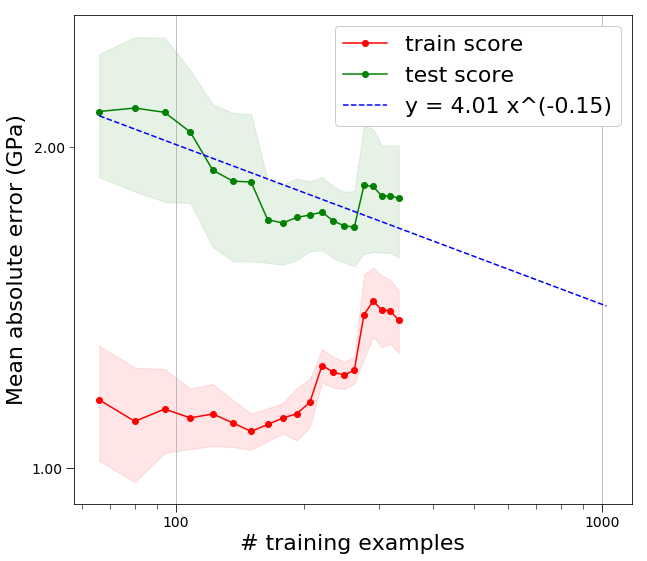

In [55]:
figs = []
for target_prop in target_props:
    figs += [make_learning_curve(X_LBoB, target_prop, savefig=False)]

[ 0.96003416  0.27048729]


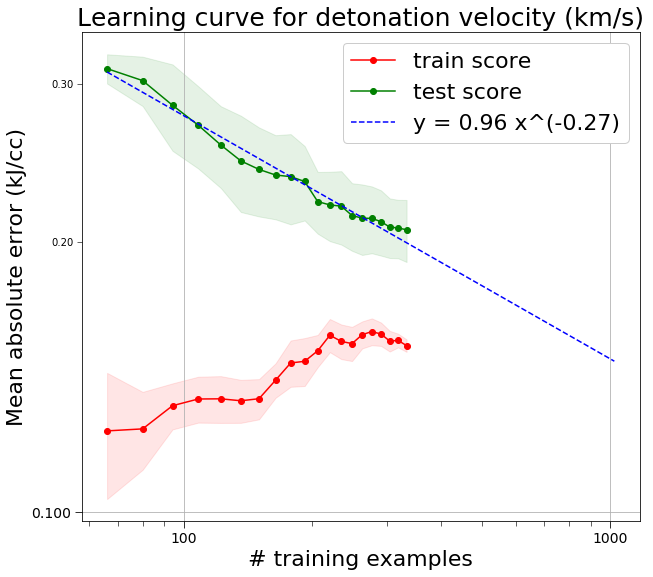

[ 4.74601166  0.18080265]


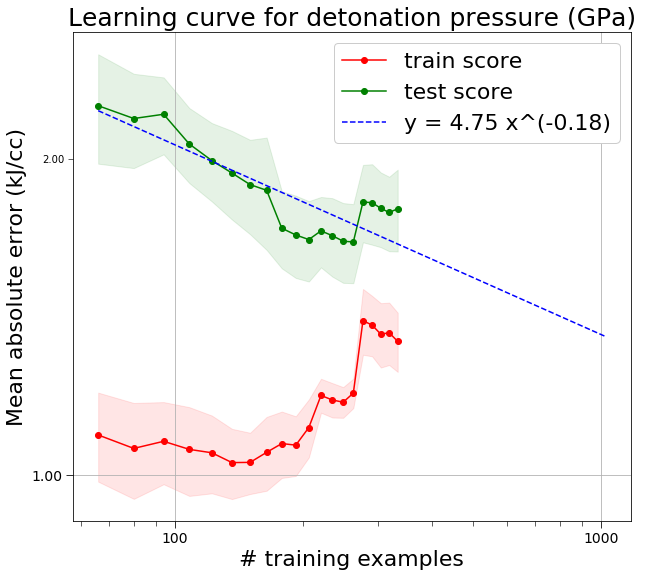

In [9]:
figs = []
for target_prop in target_props:
    figs += [make_learning_curve(X_LBoB, target_prop, savefig=False)]

In [ ]:
fig = make_learning_curve(X_LBoB, target_props, savefig=True)
